In [ ]:
using InstantiateFromURL
activate_github("QuantEcon/QuantEconLecturePackages", tag="v0.3.1");

### Exercise 1

Explore the package [StaticArrays.jl](https://github.com/JuliaArrays/StaticArrays.jl)

>StaticArrays provides a framework for implementing statically sized arrays in Julia (≥ 0.5), using the abstract type `StaticArray{Size,T,N} <: AbstractArray{T,N}`. Subtypes of `StaticArray` will provide fast implementations of common array and linear algebra operations. Note that here "statically sized" means that the size can be determined from the type, and "static" does not necessarily imply immutable.

Translation: StaticArrays is a package that makes linear algebra calculations faster by telling Julia the dimensions of a matrix in its type.

In [346]:
using Pkg
Pkg.add("StaticArrays")
using StaticArrays

 Resolving package versions...


Pkg.Types.ResolverError: Unsatisfiable requirements detected for package GR [28b8d3ca]:
 GR [28b8d3ca] log:
 ├─possible versions are: [0.1.0, 0.2.0, 0.3.0, 0.4.0, 0.5.0, 0.6.0, 0.7.0, 0.8.0, 0.9.0-0.9.17, 0.10.0, 0.11.0, 0.12.0, 0.13.0, 0.14.0, 0.15.0, 0.16.0, 0.17.0, 0.18.0, 0.19.0, 0.20.0, 0.21.0, 0.22.0, 0.23.0, 0.24.0, 0.25.0, 0.26.0, 0.28.0, 0.29.0, 0.30.0, 0.31.0, 0.32.0-0.32.3, 0.33.1, 0.34.0-0.34.1, 0.35.0] or uninstalled
 ├─restricted to versions 0.34.1 by an explicit requirement, leaving only versions 0.34.1
 └─restricted by julia compatibility requirements to versions: 0.35.0 or uninstalled — no versions left

- Describe 2 abstract types and the hierarchy of 3 different concrete types 

The abstract types in `StaticArrays` look like this `StaticArray{Size,T,N}`. `Size` gives the dimensions of the array, `T` gives the type, and `N` gives the number of dimensions. So `StaticArray{Tuple{2,1},Int64,2})` contains integer-valued 2 dimensional 2-by-1 tuples..? Something like that. Similarly, `StaticArray{Tuple{1,1},Real,1}` would contain real-valued scalars.

In [347]:
@show subtypes(StaticArray{Tuple{2,1},Int64,2})
@show subtypes(StaticArray{Tuple{1,1},Real,1})

subtypes(StaticArray{Tuple{2, 1}, Int64, 2}) = Any[MArray{Tuple{2,1},Int64,2,L} where L, SArray{Tuple{2,1},Int64,2,L} where L, SizedArray{Tuple{2,1},Int64,2,M} where M]
subtypes(StaticArray{Tuple{1, 1}, Real, 1}) = Any[MArray{Tuple{1,1},Real,1,L} where L, SArray{Tuple{1,1},Real,1,L} where L, SizedArray{Tuple{1,1},Real,1,M} where M]


3-element Array{Any,1}:
 MArray{Tuple{1,1},Real,1,L} where L    
 SArray{Tuple{1,1},Real,1,L} where L    
 SizedArray{Tuple{1,1},Real,1,M} where M

The concrete types are `SVector`, `SMatrix` and `SArray`. Their hierarchies:

In [348]:
@show supertype(SVector)
@show subtypes(SVector)
@show supertype(SMatrix)
@show subtypes(SMatrix)
@show supertype(SArray)
@show subtypes(SArray)

supertype(SVector) = StaticArray{Tuple{S},T,1} where T where S
subtypes(SVector) = Type[]
supertype(SMatrix) = StaticArray{Tuple{S1,S2},T,2} where T where S2 where S1
subtypes(SMatrix) = Type[]
supertype(SArray) = StaticArray
subtypes(SArray) = Type[]


0-element Array{Type,1}

- Benchmark the calculation of some simple linear algebra with a static array compared to the following for a dense arrays for `N=3` and `N=15`  

In [349]:
using BenchmarkTools
Ns = [3 15]

for N in Ns
A = rand(N, N) 
x = rand(N) 
@btime $A * $x  # the $ in front of variable names is sometimes important
@btime inv($A) 
end

  76.883 ns (1 allocation: 112 bytes)
  602.210 ns (5 allocations: 1.98 KiB)
  129.007 ns (1 allocation: 208 bytes)
  10.833 μs (5 allocations: 9.88 KiB)


The calculations above were done with "dense arrays" (the normal kind of arrays, i.e., not static arrays). Now Jesse wants us to do the same calculations with static arrays and see if they're faster:

In [350]:
using BenchmarkTools
Ns = [3 15]

for N in Ns
A = @SMatrix(rand(N,N))
x = @SVector(rand(N))
@btime $A * $x
@btime inv($A)
end

  5.300 ns (0 allocations: 0 bytes)
  21.888 ns (0 allocations: 0 bytes)
  55.295 ns (0 allocations: 0 bytes)
  17.200 μs (6 allocations: 11.86 KiB)


### Exercise 2

A key step in the calculation of the Kalman Filter is calculation of the Kalman gain, as can be seen with the following example using dense matrices from [this lecture](kalman)

Using what you learned from Exercise 1, benchmark this using Static Arrays

In [351]:
using LinearAlgebra

Σ = [0.4  0.3;
    0.3 0.45] ;
G = I ;
R = 0.5 * Σ ;

gain(Σ, G, R) = Σ * G' * inv(G * Σ * G' + R);
dense = @belapsed gain($Σ, $G, $R) ;


In [352]:
using LinearAlgebra

Σ = @SMatrix([0.4  0.3; 0.3 0.45]) ;
G = I ;
R = 0.5 * Σ ;

gain(Σ, G, R) = Σ * G' * inv(G * Σ * G' + R);
static = @belapsed gain($Σ, $G, $R) ;

How many times faster are static arrays in this example?

In [353]:
print("$(dense/static) times faster! Wow!!!!!!!!!")

149.2045390070922 times faster! Wow!!!!!!!!!

### Exercise 3

The [Polynomial.jl](https://github.com/JuliaMath/Polynomials.jl) provides a package for simple univariate Polynomials

In [354]:
using Polynomials
p = Poly([2, -5, 2], :x) # :x just gives a symbol for display
@show p
p′ = polyder(p) # gives the derivative of p, another polynomial
@show p(0.1), p′(0.1) # call like a function
@show roots(p); # find roots such that p(x) = 0

p = Poly(2 - 5*x + 2*x^2)
(p(0.1), p′(0.1)) = (1.52, -4.6)
roots(p) = [2.0, 0.5]


Plot both `p(x)` and `p′(x)` for $ x \in [-2, 2] $

In [355]:
X = collect(-2:4/100:2) ;
PandPprime = [p(X) p′(X)];

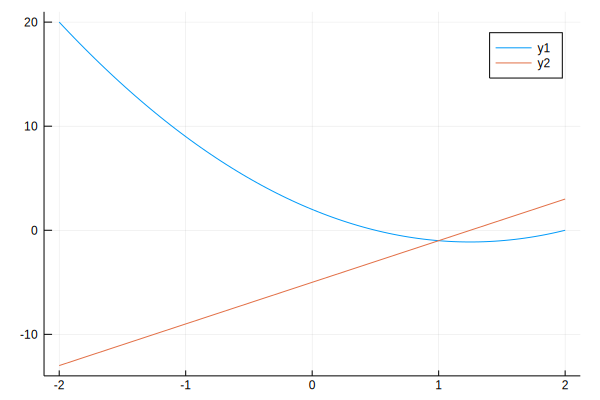

In [356]:
using Plots
plot(X, PandPprime)

### Exercise 4

Using your solution to Exercise 8(a/b) in the [Julia By Example Lecture](julia_by_example) to create a specialized version of Newton’s method for Polynomials, using the `polyder` function

The signature of the function should be `newtonsmethod(p::Poly, x_0; tolerance = 1E-7, maxiter = 100)`, where the `p::Poly` ensure that this version of the function will be used anytime a polynomial is passed (i.e. dispatch)

Compare the results of this function to the built in `roots(p)`

Instead of using my solution to Exercise 8, I'm going to steal Jesse's:

In [357]:
function newtonsmethod(f, f′; x₀, tolerance = 1E-7, maxiter = 1000)
    # setup the algorithm
    x_old = x₀
    normdiff = Inf
    iter = 1
    while normdiff > tolerance && iter <= maxiter
        x_new = x_old - f(x_old)/f′(x_old) # use the passed in map
        normdiff = norm(x_new - x_old)
        x_old = x_new
        iter = iter + 1
    end
    return (root = x_old, normdiff = normdiff, iter = iter) # A named tuple
end

newtonsmethod (generic function with 1 method)

In [358]:
function newtonroot(p::Poly, x₀; tolerance = 1E-7, maxiter = 100)
    # setup the algorithm
    x_old = x₀
    normdiff = Inf
    iter = 1
    while normdiff > tolerance && iter <= maxiter
        x_new = x_old - p(x_old)/p′(x_old) # use the passed in map
        normdiff = norm(x_new - x_old)
        x_old = x_new
        iter = iter + 1
    end
    return (root = x_old, normdiff = normdiff, iter = iter) # A named tuple
end

newtonroot (generic function with 3 methods)

In [359]:
p = Poly([2, -5, 2], :x)
newtonroot(p, 1.5)

(root = 2.0, normdiff = 3.4924596548080444e-10, iter = 7)

### Exercise 5 (Advanced)

The [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule)  approximate an integral with

$$
\int_\underline{x}^\bar{x} f(x) \, dx \approx \sum_{n=1}^N \frac{f(x_{n-1}) + f(x_n)}{2} \Delta x_n
$$

where $ x_0 = \underline{x},\, x_N = \bar{x} $, and $ \Delta x_n \equiv x_{n-1} - x_n $

Given an `x` and a function `f`, implement a few variations of the trapezoidal rule using multiple-dispatch

- `trapezoidal(f, x)` for any `typeof(x) = AbstractArray` and `typeof(f) == AbstractArray` where `length(x) = length(f)`  

In [360]:
function trapezoidal(f::AbstractArray,x::AbstractArray)
    @assert length(x)==length(f)
    N = length(x)
    sum = 0.0
    for i in 2:N
        sum+=(f[i-1]+f[i])/2*(x[i-1]-x[i])
    end
    return sum
end

trapezoidal (generic function with 4 methods)

- `trapezoidal(f, x)` for any `typeof(x) = AbstractRange` and `typeof(f) == AbstractArray` where `length(x) = length(f)`
  * exploit the fact that `AbstractRange` have constant step sizes to specialize the algorithm  

In [361]:
function trapezoidal(f::AbstractArray, x::AbstractRange)
    @assert length(f)==length(x)
    N=length(x)
    sum=0.0
    for i in 2:N
        sum+=(f[i-1]+f[i])/2
    end
    sum*step(x)
end

trapezoidal (generic function with 4 methods)

- `trapezoidal(f, x̲, x̄, N)` where `typeof(f) = Function`, and the other arguments are `Real`
  * for this, build a uniform grid with `N` points on `[x̲,x̄]`, call the `f` function at those grid points, and use the existing `trapezoidal(f, x)` from the implementation  

In [362]:
function trapezoidal(f::Function, x̄::Real, x̲::Real, N::Real)
    x = range(x̄, x̲, length = N)
    sum = 0.0
    for i in 2:N
        sum+= (f(x[i-1])+f(x[i]))/2
        end
        return sum*step(x)
end

trapezoidal (generic function with 4 methods)

With these,

Test each variation of the function with $ f(x) = x^2 $ with $ \underline{x}=0,\, \bar{x} = 1 $

In [363]:
#AbstractArray
xsquared(x) = x^2;
x = collect(0:0.01:1);
f = xsquared.(x);
@show typeof(x) <: AbstractArray; @show typeof(f) <: AbstractArray;
trapezoidal(f,x)

typeof(x) <: AbstractArray = true
typeof(f) <: AbstractArray = true


-0.33335000000000004

In [364]:
#AbstractRange
x = range(0,1,length=101);
f = xsquared.(x);
@show typeof(x) <: AbstractRange; @show typeof(f) <: AbstractArray;
trapezoidal(f,x)

typeof(x) <: AbstractRange = true
typeof(f) <: AbstractArray = true


0.3333499999999999

In [365]:
#Generic function
trapezoidal(xsquared,0,1,101)

0.3333499999999999

From the analytical solution of the function, plot the error of `trapezoidal(f, x̲, x̄, N)` relative to the analytical solution for a grid of different `N` values

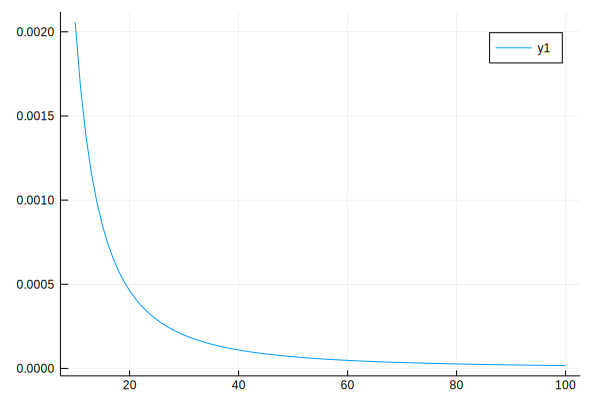

In [366]:
Ns = collect(10:100);
trapezoidalerror(f,N,truevalue) = abs(trapezoidal(f,0,1,N)-truevalue)
plot(Ns,trapezoidalerror.(xsquared,Ns,1/3))

3. Consider trying different functions for $ f(x) $ and comparing the solutions for various `N`

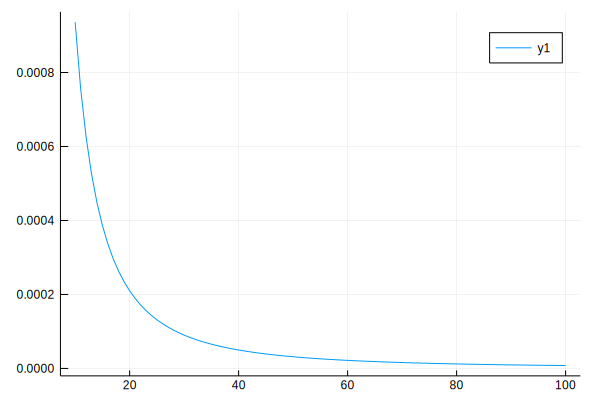

In [404]:
using QuadGK
#coolfunction(x) = (sin(x)^2/sqrt(1+x^2))^(5/7)
coolfunction(x) = sin(x)^2

quadgk(coolfunction,0.0,1.0)[1]
plot(Ns,trapezoidalerror.(coolfunction,Ns,quadgk(coolfunction,0.0,1.0)[1]))


### Exercise 6 (Advanced)

Take a variation of your code in Exercise 5 which implements the trapezoidal rule for the uniform grid

Use auto-differentiation to calculate the following derivative for the example functions

$$
\frac{d}{d \bar{x}}\int_\underline{x}^\bar{x} f(x) \, dx
$$



In [373]:
using ForwardDiff
Df(f,x) = ForwardDiff.derivative(y -> trapezoidal(f,0.0,y,50), x)


Df (generic function with 2 methods)

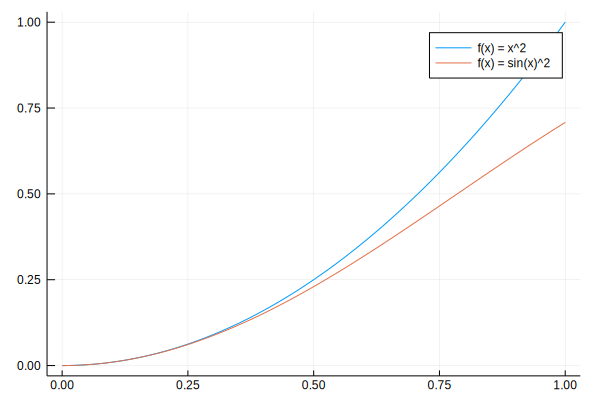

In [414]:
X = collect(0:1/100:1)
plot(X,Df.(xsquared,X), label="f(x) = x^2")
plot!(X,Df.(Ref(coolfunction),X), label="f(x) = sin(x)^2")